# Opioid Crisis - Analysis

I want to take a second look at the data from the Opioid Crisis datasheet.

- (link here: https://www.mathmodels.org/Problems/2019/MCM-C/index.html)

Motivation: was part of the MCM 2019.

Data we will work with:
* Drug identification counts in years 2010-2016
* Socio-economic factors collected for five states (Ohio, Kentucky, West Virginia, Virginia, Pennsylvania)

In [1]:
import numpy as np
import pandas as pd

# drug use data.
df_nflis = pd.read_excel('2018_MCMProblemC_DATA/MCM_NFLIS_Data.xlsx', sheet_name="Data")

# socio-economic data.
df10 = pd.read_csv('2018_MCMProblemC_DATA/ACS_10_5YR_DP02/ACS_10_5YR_DP02_with_ann.csv')
df11 = pd.read_csv('2018_MCMProblemC_DATA/ACS_11_5YR_DP02/ACS_11_5YR_DP02_with_ann.csv')
df12 = pd.read_csv('2018_MCMProblemC_DATA/ACS_12_5YR_DP02/ACS_12_5YR_DP02_with_ann.csv')
df13 = pd.read_csv('2018_MCMProblemC_DATA/ACS_13_5YR_DP02/ACS_13_5YR_DP02_with_ann.csv')
df14 = pd.read_csv('2018_MCMProblemC_DATA/ACS_14_5YR_DP02/ACS_14_5YR_DP02_with_ann.csv')
df15 = pd.read_csv('2018_MCMProblemC_DATA/ACS_15_5YR_DP02/ACS_15_5YR_DP02_with_ann.csv')
df16 = pd.read_csv('2018_MCMProblemC_DATA/ACS_16_5YR_DP02/ACS_16_5YR_DP02_with_ann.csv')

# indexing data.
df10_meta = pd.read_csv('2018_MCMProblemC_DATA/ACS_10_5YR_DP02/ACS_10_5YR_DP02_metadata.csv')
df11_meta = pd.read_csv('2018_MCMProblemC_DATA/ACS_11_5YR_DP02/ACS_11_5YR_DP02_metadata.csv')
df12_meta = pd.read_csv('2018_MCMProblemC_DATA/ACS_12_5YR_DP02/ACS_12_5YR_DP02_metadata.csv')
df13_meta = pd.read_csv('2018_MCMProblemC_DATA/ACS_13_5YR_DP02/ACS_13_5YR_DP02_metadata.csv')
df14_meta = pd.read_csv('2018_MCMProblemC_DATA/ACS_14_5YR_DP02/ACS_14_5YR_DP02_metadata.csv')
df15_meta = pd.read_csv('2018_MCMProblemC_DATA/ACS_15_5YR_DP02/ACS_15_5YR_DP02_metadata.csv')
df16_meta = pd.read_csv('2018_MCMProblemC_DATA/ACS_16_5YR_DP02/ACS_16_5YR_DP02_metadata.csv')

Parts of the data are not available.

## Preprocessing

General plan: iterate over socio-economic data, and append with relevant drug use data.

Feature extraction part:
* Include geography (specifically `GEO.display-label`).
* Exclude margin of error features.
* Exclude columns with `(X)`.
* Exclude non-universal data.

In [2]:
df10

,GEO.id,GEO.id2,GEO.display-label,HC01_VC03,HC02_VC03,HC03_VC03,HC04_VC03,HC01_VC04,HC02_VC04,HC03_VC04,...,HC03_VC207,HC04_VC207,HC01_VC208,HC02_VC208,HC03_VC208,HC04_VC208,HC01_VC209,HC02_VC209,HC03_VC209,HC04_VC209
0,Id,Id2,Geography,Estimate; HOUSEHOLDS BY TYPE - Total households,Estimate Margin of Error; HOUSEHOLDS BY TYPE -...,Percent; HOUSEHOLDS BY TYPE - Total households,Percent Margin of Error; HOUSEHOLDS BY TYPE - ...,Estimate; HOUSEHOLDS BY TYPE - Family househol...,Estimate Margin of Error; HOUSEHOLDS BY TYPE -...,Percent; HOUSEHOLDS BY TYPE - Family household...,...,Percent; ANCESTRY - Ukrainian,Percent Margin of Error; ANCESTRY - Ukrainian,Estimate; ANCESTRY - Welsh,Estimate Margin of Error; ANCESTRY - Welsh,Percent; ANCESTRY - Welsh,Percent Margin of Error; ANCESTRY - Welsh,Estimate; ANCESTRY - West Indian (excluding Hi...,Estimate Margin of Error; ANCESTRY - West Indi...,Percent; ANCESTRY - West Indian (excluding His...,Percent Margin of Error; ANCESTRY - West India...
1,0500000US21001,21001,"Adair County, Kentucky",7272,270,7272,(X),5004,262,68.8,...,0.0,0.2,199,139,1.1,0.8,7,11,0.0,0.1
2,0500000US21003,21003,"Allen County, Kentucky",7811,291,7811,(X),5526,331,70.7,...,0.0,0.2,12,18,0.1,0.1,0,123,0.0,0.2
3,0500000US21005,21005,"Anderson County, Kentucky",8319,205,8319,(X),6148,302,73.9,...,1.0,1.3,137,98,0.6,0.5,0,123,0.0,0.2
4,0500000US21007,21007,"Ballard County, Kentucky",3363,146,3363,(X),2408,144,71.6,...,0.0,0.4,35,24,0.4,0.3,14,19,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,0500000US54101,54101,"Webster County, West Virginia",4116,214,4116,(X),2927,236,71.1,...,0.1,0.2,4,8,0.0,0.1,0,119,0.0,0.4
461,0500000US54103,54103,"Wetzel County, West Virginia",6897,223,6897,(X),4725,239,68.5,...,0.0,0.2,173,91,1.0,0.5,0,119,0.0,0.2
462,0500000US54105,54105,"Wirt County, West Virginia",2364,170,2364,(X),1697,211,71.8,...,0.0,0.6,15,23,0.3,0.4,27,30,0.5,0.5
463,0500000US54107,54107,"Wood County, West Virginia",36222,475,36222,(X),23934,562,66.1,...,0.1,0.1,569,169,0.7,0.2,0,119,0.0,0.1


The function `feature_extract` will extract features as to satisfy the above conditions (save universality).

In [3]:
from opioid_crisis_lib import feature_extract
df10[feature_extract(df10, df10_meta)]

,GEO.display-label,HC01_VC03,HC01_VC04,HC01_VC06,HC01_VC07,HC01_VC08,HC01_VC09,HC01_VC10,HC01_VC11,HC01_VC12,...,HC01_VC200,HC01_VC201,HC01_VC202,HC01_VC203,HC01_VC204,HC01_VC205,HC01_VC206,HC01_VC207,HC01_VC208,HC01_VC209
0,Geography,Estimate; HOUSEHOLDS BY TYPE - Total households,Estimate; HOUSEHOLDS BY TYPE - Family househol...,Estimate; HOUSEHOLDS BY TYPE - Family househol...,Estimate; HOUSEHOLDS BY TYPE - Family househol...,Estimate; HOUSEHOLDS BY TYPE - Family househol...,Estimate; HOUSEHOLDS BY TYPE - Family househol...,Estimate; HOUSEHOLDS BY TYPE - Family househol...,Estimate; HOUSEHOLDS BY TYPE - Family househol...,Estimate; HOUSEHOLDS BY TYPE - Family househol...,...,Estimate; ANCESTRY - Russian,Estimate; ANCESTRY - Scotch-Irish,Estimate; ANCESTRY - Scottish,Estimate; ANCESTRY - Slovak,Estimate; ANCESTRY - Subsaharan African,Estimate; ANCESTRY - Swedish,Estimate; ANCESTRY - Swiss,Estimate; ANCESTRY - Ukrainian,Estimate; ANCESTRY - Welsh,Estimate; ANCESTRY - West Indian (excluding Hi...
1,"Adair County, Kentucky",7272,5004,1945,4124,1506,377,160,503,279,...,0,370,81,0,69,20,2,0,199,7
2,"Allen County, Kentucky",7811,5526,2363,4011,1519,476,222,1039,622,...,0,350,335,24,0,0,0,0,12,0
3,"Anderson County, Kentucky",8319,6148,2771,4848,1891,267,168,1033,712,...,148,671,438,0,29,84,74,204,137,0
4,"Ballard County, Kentucky",3363,2408,1001,2001,725,193,137,214,139,...,17,253,83,8,11,101,0,0,35,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,"Webster County, West Virginia",4116,2927,1189,2365,884,216,123,346,182,...,40,325,193,0,0,45,0,9,4,0
461,"Wetzel County, West Virginia",6897,4725,1728,3845,1275,198,104,682,349,...,63,280,351,61,0,147,114,0,173,0
462,"Wirt County, West Virginia",2364,1697,601,1447,441,64,31,186,129,...,0,60,179,0,0,0,0,0,15,27
463,"Wood County, West Virginia",36222,23934,9622,18641,6666,1400,788,3893,2168,...,223,2101,1965,235,192,248,347,72,569,0


### Filtering Data with Universal Property

We can only work with properties that are present for all dataframes.

At the same time, the heterogenous nature of labels corresponding to the same descriptor across years prompts us to address that as well, with the following map:
$$\mathrm{descriptor}\mapsto(\mathrm{year}\mapsto\mathrm{label})$$

In [4]:
from opioid_crisis_lib import feature_index
from opioid_crisis_lib import feature_index2

# ddf = [df10, df11, df12, df13, df14, df15, df16]
# ddf_metadata = [df10_meta, df11_meta, df12_meta, df13_meta, df14_meta, df15_meta, df16_meta]

ddf_yyyy = {
    "2010": df10,
    "2011": df11,
    "2012": df12,
    "2013": df13,
    "2014": df14,
    "2015": df15,
    "2016": df16,
}
ddf_metadata_yyyy = {
    "2010": df10_meta,
    "2011": df11_meta,
    "2012": df12_meta,
    "2013": df13_meta,
    "2014": df14_meta,
    "2015": df15_meta,
    "2016": df16_meta,
}

# f_index = feature_index(ddf, ddf_metadata)
# sorted(f_index)

f_index = feature_index2(ddf_yyyy, ddf_metadata_yyyy)
sorted(f_index)

['Estimate; ANCESTRY - Total population',
 'Estimate; EDUCATIONAL ATTAINMENT - Population 25 years and over',
 'Estimate; FERTILITY - Number of women 15 to 50 years old who had a birth in the past 12 months',
 'Estimate; GRANDPARENTS - Number of grandparents living with own grandchildren under 18 years',
 'Estimate; GRANDPARENTS - Number of grandparents responsible for own grandchildren under 18 years',
 'Estimate; HOUSEHOLDS BY TYPE - Households with one or more people 65 years and over',
 'Estimate; HOUSEHOLDS BY TYPE - Households with one or more people under 18 years',
 'Estimate; HOUSEHOLDS BY TYPE - Total households',
 'Estimate; LANGUAGE SPOKEN AT HOME - Population 5 years and over',
 'Estimate; MARITAL STATUS - Females 15 years and over',
 'Estimate; MARITAL STATUS - Males 15 years and over',
 'Estimate; PLACE OF BIRTH - Total population',
 'Estimate; RELATIONSHIP - Population in households',
 'Estimate; RESIDENCE 1 YEAR AGO - Population 1 year and over',
 'Estimate; SCHOOL ENR

As we see only the "important" data remain. We've gotten rid of error estimate data as well as inadmissible data.

Given a particular year we want to extract all universal relevant labels. In other words, we want the map:
$$
\left(\mathrm{descriptor}\mapsto(\mathrm{year}\mapsto\mathrm{label})\right)
\mapsto\left(\mathrm{year}\mapsto(\mathrm{labels})\right)
$$

In [5]:
from opioid_crisis_lib import label_from_feature_index
label_from_feature_index("2012", f_index)

['HC01_VC98',
 'HC01_VC182',
 'HC01_VC150',
 'HC01_VC42',
 'HC01_VC138',
 'HC01_VC51',
 'HC01_VC156',
 'HC01_VC35',
 'HC01_VC146',
 'HC01_VC117',
 'HC01_VC84',
 'HC01_VC144',
 'HC01_VC17',
 'HC01_VC61',
 'HC01_VC18',
 'HC01_VC69',
 'HC01_VC166',
 'HC01_VC25',
 'HC01_VC128',
 'HC01_VC03',
 'HC01_VC75']

In [6]:
f_index['Estimate; ANCESTRY - Total population']

{'2010': 'HC01_VC182',
 '2011': 'HC01_VC182',
 '2012': 'HC01_VC182',
 '2013': 'HC01_VC185',
 '2014': 'HC01_VC185',
 '2015': 'HC01_VC185',
 '2016': 'HC01_VC185'}

We obtain a map from descriptors to corresponding labels. This allows us to go back and forth between description and label.

The above data corresponds to the socio-economic data of a particular county at some specified year. When we go over drug use data, the `YYYY`, `State` and `County` data should sufficiently return the appropriate socio-economic data.

The following short function returns the state and county of a string as separate strings, with state written in initials.

In [7]:
from opioid_crisis_lib import state_and_county
state_and_county("Adair County, Kentucky")

('ky', 'Adair', 'Kentucky')

### Retrieving Geographic Data

In addition, for each county there should be a method to retrieve numerical geographic data:

In [8]:
df_geo = pd.read_csv('2021_Gaz_counties_national.txt', sep="\t")
from opioid_crisis_lib import locate
locate("ky", "adair", df_geo)

(37.105559, -85.28138)

In [9]:
np.array(df_geo[["USPS", "NAME"]])

array([['AL', 'Autauga County'],
       ['AL', 'Baldwin County'],
       ['AL', 'Barbour County'],
       ...,
       ['PR', 'Villalba Municipio'],
       ['PR', 'Yabucoa Municipio'],
       ['PR', 'Yauco Municipio']], dtype=object)

### Processing Drug Data

In [10]:
df_nflis[["YYYY", "State", "COUNTY", "SubstanceName", "DrugReports"]]

,YYYY,State,COUNTY,SubstanceName,DrugReports
0,2010,VA,ACCOMACK,Propoxyphene,1
1,2010,OH,ADAMS,Morphine,9
2,2010,PA,ADAMS,Methadone,2
3,2010,VA,ALEXANDRIA CITY,Heroin,5
4,2010,PA,ALLEGHENY,Hydromorphone,5
...,...,...,...,...,...
24057,2017,VA,WYTHE,Codeine,1
24058,2017,VA,WYTHE,Hydrocodone,19
24059,2017,VA,WYTHE,Tramadol,5
24060,2017,PA,YORK,ANPP,1


Of importance is the type of drugs reported.

In [11]:
df_nflis["SubstanceName"]

0         Propoxyphene
1             Morphine
2            Methadone
3               Heroin
4        Hydromorphone
             ...      
24057          Codeine
24058      Hydrocodone
24059         Tramadol
24060             ANPP
24061           Heroin
Name: SubstanceName, Length: 24062, dtype: object

The following gives a survey of distinct drug types (indexed).

In [12]:
substanceNames = sorted(set(df_nflis["SubstanceName"]))
substanceNames

['3,4-Methylenedioxy U-47700',
 '3-Fluorofentanyl',
 '3-Methylfentanyl',
 '4-Fluoroisobutyryl fentanyl',
 '4-Methylfentanyl',
 'ANPP',
 'Acetyl fentanyl',
 'Acetylcodeine',
 'Acetyldihydrocodeine',
 'Acryl fentanyl',
 'Alphaprodine',
 'Benzylfentanyl',
 'Buprenorphine',
 'Butorphanol',
 'Butyryl fentanyl',
 'Carfentanil',
 'Codeine',
 'Crotonyl fentanyl',
 'Cyclopentyl fentanyl',
 'Cyclopropyl fentanyl',
 'Cyclopropyl/Crotonyl Fentanyl',
 'Desmethylprodine ',
 'Dextropropoxyphene',
 'Dihydrocodeine',
 'Dihydromorphone',
 'Fentanyl',
 'Fluorobutyryl fentanyl ',
 'Fluorofentanyl',
 'Fluoroisobutyryl fentanyl',
 'Furanyl fentanyl',
 'Furanyl/3-Furanyl fentanyl',
 'Heroin',
 'Hydrocodeinone',
 'Hydrocodone',
 'Hydromorphone',
 'Isobutyryl fentanyl',
 'Levorphanol',
 'MT-45',
 'Meperidine',
 'Metazocine',
 'Methadone',
 'Methorphan',
 'Methoxyacetyl fentanyl',
 'Mitragynine',
 'Morphine',
 'Nalbuphine',
 'Opiates',
 'Opium',
 'Oxycodone',
 'Oxymorphone',
 'Pentazocine',
 'Pethidine',
 'Phen

In [13]:
print(len(substanceNames))

69


Convert this to a dictionary so we can map substance use to a particular index.

In [14]:
substanceNamesDict = {substanceNames[i]:i for i in range(69)}

Given data on `drug reports` and `substance name`, we can construct a vector which indicates extent of a particular drug use in a county.

In [15]:
from opioid_crisis_lib import drug_matrix
drug_matrix(df_nflis, substanceNamesDict)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now due to redundancy, a single county may occur multiple times. We want to have one drug vector per county.

In [16]:
from opioid_crisis_lib import drug_vector
drug_vector("2010", "oh", "adams", df_nflis, substanceNamesDict, identify=True)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   6.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  50.,   0.,
         59.,   4.,   0.,   0.,   0.,   1.,   0.,  12.,   0.,   0.,   0.,
          9.,   0.,   0.,   0., 119.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.]),
 {'Morphine': 9,
  'Buprenorphine': 6,
  'Heroin': 50,
  'Tramadol': 1,
  'Codeine': 3,
  'Hydrocodone': 59,
  'Methadone': 12,
  'Hydromorphone': 4,
  'Meperidine': 1,
  'Oxycodone': 119,
  'Oxymorphone': 1})

### Compiling Data

We can do this:
1. Determine the overall dimension of the sample matrix. (doable)
1. Iterate through socio-economic dataframe rows, through the years 2010-2016,
    1. For each row, gather socio-economic data, AND data which identifies the State, county and year.
    1. Retrieve the geographic location of the county, append.
    1. Retrieve the drug vector of the county, append.
2. Write all appended data into one numpy array.
3. (Optional) Move independent columns (geographical location, socio-economic data) to the beginning, and the drug vector to the end.

**Note**: even with previous filtering, there are still socio-economic sample points with `(X)` terms. These terms are set to 0. (Not the best approach. we'll deal with this later. But I assume that these anomalous rows only take a small portion and are negligible.)

**Note**: turns out that the drug data contains data up to 2017, which is not included in the socio-economic data. However, this new data also contains new drugs, which messes up the data (since the new-drug column is a column of zeros, which messes up pca and all that).

Make sure the data is recoverable and that rows have unique identifiers. (which indicate year, state and county)

In [17]:
# from opioid_crisis_lib import generate_sample
# sample = generate_sample(ddf_yyyy, ddf_metadata_yyyy, f_index, df_nflis, substanceNamesDict, df_geo)
# sample

In [18]:
# np.savetxt("please_dont_overwrite.csv", sample, delimiter=",")

In [19]:
sample_read = pd.read_csv('please_dont_overwrite.csv', header=None)
sample_read

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,37.105559,-85.281380,4541.0,236.0,2113.0,18542.0,18378.0,271.0,7272.0,2258.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36.750770,-86.192458,4549.0,314.0,1995.0,19688.0,19416.0,477.0,7811.0,2662.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38.005396,-84.986417,5407.0,369.0,1719.0,21080.0,20857.0,517.0,8319.0,3137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,37.051323,-89.010367,1911.0,51.0,987.0,8225.0,8080.0,51.0,3363.0,1064.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36.962805,-85.932108,9693.0,605.0,4591.0,41685.0,41150.0,1109.0,16727.0,5565.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3240,38.483459,-80.449052,1492.0,206.0,1351.0,8820.0,8743.0,479.0,3952.0,1154.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3241,39.598180,-80.635399,3021.0,182.0,2333.0,15997.0,15766.0,378.0,6238.0,1435.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3242,39.020034,-81.382975,1102.0,16.0,777.0,5826.0,5747.0,37.0,2432.0,545.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3243,39.211602,-81.516234,18959.0,862.0,11546.0,86262.0,85254.0,1718.0,36225.0,10278.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Convert to np.array.

In [20]:
sample_read_np = sample_read.to_numpy()
sample_read_np

array([[   37.105559,   -85.28138 ,  4541.      , ...,     0.      ,
            0.      ,     0.      ],
       [   36.75077 ,   -86.192458,  4549.      , ...,     0.      ,
            0.      ,     0.      ],
       [   38.005396,   -84.986417,  5407.      , ...,     0.      ,
            0.      ,     0.      ],
       ...,
       [   39.020034,   -81.382975,  1102.      , ...,     0.      ,
            0.      ,     0.      ],
       [   39.211602,   -81.516234, 18959.      , ...,     0.      ,
            0.      ,     0.      ],
       [   37.60366 ,   -81.549032,  4428.      , ...,     0.      ,
            0.      ,     0.      ]])

### Extraction of Nonzero Columns (features) and Problematic Rows (sample points)

For a column feature, we need to make sure that the column is nonzero. This is because if a column $c$ is zero, the *standardization* $$\dfrac{c - \mathrm{mean}\,(c)}{\mathrm{std}\,(c)}$$ is undefined (in this case it is `nan`).

Additionally, there still exist sample points with `nan` entries in the first and second rows (when the county location cannot be found). We will also remove those too.

In [21]:
from opioid_crisis_lib import find_nonzero, keep_rows, keep_cols
nonzero_index, zero_index = find_nonzero(sample_read_np.T)
zero_index

[23, 27, 34, 40, 41, 43, 58, 62, 65, 75, 82, 83, 84]

Identify the features these zero indices correspond to.

In [22]:
geo_features = np.array(["INTPTLAT", "INTPTLONG                                                                                                               "])
features = np.concatenate((geo_features, 
                          sorted(f_index),
                          sorted(substanceNamesDict)))

In [23]:
features[zero_index]

array(['3,4-Methylenedioxy U-47700', '4-Methylfentanyl', 'Benzylfentanyl',
       'Crotonyl fentanyl', 'Cyclopentyl fentanyl',
       'Cyclopropyl/Crotonyl Fentanyl', 'Isobutyryl fentanyl',
       'Metazocine', 'Methoxyacetyl fentanyl', 'Phenyl fentanyl',
       'U-48800', 'U-49900', 'U-51754'], dtype='<U120')

Identify the features the nonzero indices correspond to.

In [24]:
nonzero_features = features[nonzero_index]
nonzero_features

array(['INTPTLAT',
       'INTPTLONG                                                                                                               ',
       'Estimate; ANCESTRY - Total population',
       'Estimate; EDUCATIONAL ATTAINMENT - Population 25 years and over',
       'Estimate; FERTILITY - Number of women 15 to 50 years old who had a birth in the past 12 months',
       'Estimate; GRANDPARENTS - Number of grandparents living with own grandchildren under 18 years',
       'Estimate; GRANDPARENTS - Number of grandparents responsible for own grandchildren under 18 years',
       'Estimate; HOUSEHOLDS BY TYPE - Households with one or more people 65 years and over',
       'Estimate; HOUSEHOLDS BY TYPE - Households with one or more people under 18 years',
       'Estimate; HOUSEHOLDS BY TYPE - Total households',
       'Estimate; LANGUAGE SPOKEN AT HOME - Population 5 years and over',
       'Estimate; MARITAL STATUS - Females 15 years and over',
       'Estimate; MARITAL STATUS 

In [25]:
nonzero_features.shape

(79,)

These are drugs which are not included in the 2010-2016 dataframes. We will construct a matrix without these features.

In [26]:
# sample matrix with nonzero columns only.
sample_nz_col = keep_cols(sample_read_np, nonzero_index)
sample_nz_col

array([[   37.105559,   -85.28138 ,  4541.      , ...,     0.      ,
            0.      ,     0.      ],
       [   36.75077 ,   -86.192458,  4549.      , ...,     0.      ,
            0.      ,     0.      ],
       [   38.005396,   -84.986417,  5407.      , ...,     0.      ,
            0.      ,     0.      ],
       ...,
       [   39.020034,   -81.382975,  1102.      , ...,     0.      ,
            0.      ,     0.      ],
       [   39.211602,   -81.516234, 18959.      , ...,     0.      ,
            0.      ,     0.      ],
       [   37.60366 ,   -81.549032,  4428.      , ...,     0.      ,
            0.      ,     0.      ]])

Next we identify all sample points with missing location.

In [27]:
# locatable indices.
keep_row_indices = np.argwhere(~np.isnan(sample_nz_col.T[0])).T[0]
keep_row_indices

array([   0,    1,    2, ..., 3242, 3243, 3244])

In [28]:
sample_nz = sample_nz_col[keep_row_indices]
sample_nz

array([[   37.105559,   -85.28138 ,  4541.      , ...,     0.      ,
            0.      ,     0.      ],
       [   36.75077 ,   -86.192458,  4549.      , ...,     0.      ,
            0.      ,     0.      ],
       [   38.005396,   -84.986417,  5407.      , ...,     0.      ,
            0.      ,     0.      ],
       ...,
       [   39.020034,   -81.382975,  1102.      , ...,     0.      ,
            0.      ,     0.      ],
       [   39.211602,   -81.516234, 18959.      , ...,     0.      ,
            0.      ,     0.      ],
       [   37.60366 ,   -81.549032,  4428.      , ...,     0.      ,
            0.      ,     0.      ]])

Identify the sample points corresonding to the kept rows.

In [29]:
from opioid_crisis_lib import identify_sample_points
sample_point_id = identify_sample_points(keep_row_indices, ddf_yyyy)
sample_point_id

array([['2010', 'ky', 'Adair'],
       ['2010', 'ky', 'Allen'],
       ['2010', 'ky', 'Anderson'],
       ...,
       ['2016', 'wv', 'Wirt'],
       ['2016', 'wv', 'Wood'],
       ['2016', 'wv', 'Wyoming']], dtype=object)

In [30]:
sample_point_id.shape

(3007, 3)

These will be readily available.

In [31]:
sample_point_id_join = np.array([' '.join(sample_point_id[i]) for i in range(len(sample_point_id))])
sample_point_id_join

array(['2010 ky Adair', '2010 ky Allen', '2010 ky Anderson', ...,
       '2016 wv Wirt', '2016 wv Wood', '2016 wv Wyoming'], dtype='<U22')

### Standardization.

We standardize each feature column $c$: $$\tilde{c} = \dfrac{c - \mathrm{mean}\,(c)}{\mathrm{std}\,(c)}$$

In [32]:
from opioid_crisis_lib import standardize
sample_standardized = standardize(sample_nz)
sample_standardized

array([[-1.12498263, -1.16933153, -0.37244471, ..., -0.02099066,
        -0.01823919, -0.01823919],
       [-1.35792326, -1.44545842, -0.37226755, ..., -0.02099066,
        -0.01823919, -0.01823919],
       [-0.53418474, -1.07993499, -0.35326706, ..., -0.02099066,
        -0.01823919, -0.01823919],
       ...,
       [ 0.13198701,  0.01218581, -0.4486017 , ..., -0.02099066,
        -0.01823919, -0.01823919],
       [ 0.25776309, -0.02820194, -0.05315669, ..., -0.02099066,
        -0.01823919, -0.01823919],
       [-0.79794894, -0.03814226, -0.37494711, ..., -0.02099066,
        -0.01823919, -0.01823919]])

We can imbue this standardized matrix with its original features and identifiers (standardized).

In [33]:
df_standardized = pd.DataFrame(sample_standardized, index=sample_point_id_join,
                              columns=nonzero_features)
df_standardized

,INTPTLAT,INTPTLONG,Estimate; ANCESTRY - Total population,Estimate; EDUCATIONAL ATTAINMENT - Population 25 years and over,Estimate; FERTILITY - Number of women 15 to 50 years old who had a birth in the past 12 months,Estimate; GRANDPARENTS - Number of grandparents living with own grandchildren under 18 years,Estimate; GRANDPARENTS - Number of grandparents responsible for own grandchildren under 18 years,Estimate; HOUSEHOLDS BY TYPE - Households with one or more people 65 years and over,Estimate; HOUSEHOLDS BY TYPE - Households with one or more people under 18 years,Estimate; HOUSEHOLDS BY TYPE - Total households,...,Thebaine,Tramadol,U-47700,Valeryl fentanyl,cis-3-methylfentanyl,o-Fluorofentanyl,p-Fluorobutyryl fentanyl,p-Fluorofentanyl,p-methoxybutyryl fentanyl,trans-3-Methylfentanyl
2010 ky Adair,-1.124983,-1.169332,-0.372445,-0.353385,-0.394772,-0.388635,-0.388652,-0.401634,-0.383133,-0.389847,...,-0.034621,-0.280077,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239
2010 ky Allen,-1.357923,-1.445458,-0.372268,-0.295814,-0.401702,-0.381912,-0.382488,-0.341516,-0.375108,-0.369981,...,-0.034621,-0.280077,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239
2010 ky Anderson,-0.534185,-1.079935,-0.353267,-0.255220,-0.417911,-0.373746,-0.373932,-0.329842,-0.367545,-0.346624,...,-0.034621,-0.280077,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239
2010 ky Ballard,-1.160592,-2.299502,-0.430686,-0.489929,-0.460899,-0.449157,-0.449797,-0.465839,-0.441329,-0.448560,...,-0.034621,-0.280077,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239
2010 ky Barren,-1.218709,-1.366552,-0.258353,-0.081033,-0.249246,-0.252871,-0.253440,-0.157073,-0.242370,-0.227232,...,-0.034621,0.070325,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016 wv Webster,-0.220307,0.295237,-0.439965,-0.375527,-0.439523,-0.445667,-0.445861,-0.340932,-0.432560,-0.444134,...,-0.034621,-0.280077,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239
2016 wv Wetzel,0.511575,0.238759,-0.406105,-0.393241,-0.381852,-0.403564,-0.404161,-0.370408,-0.398527,-0.430316,...,-0.034621,-0.280077,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239
2016 wv Wirt,0.131987,0.012186,-0.448602,-0.515762,-0.473232,-0.463230,-0.463650,-0.469925,-0.455189,-0.474080,...,-0.034621,-0.280077,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239
2016 wv Wood,0.257763,-0.028202,-0.053157,0.108653,0.159202,0.008630,0.008433,0.020657,0.047911,0.004521,...,-0.034621,0.420727,-0.074384,-0.050605,-0.018239,-0.04259,-0.042152,-0.020991,-0.018239,-0.018239


## Principal Component Analysis

We can finally perform PCA... (with respect to the features)

Namely, we are performing PCA on the standardized sample `df_standardized`.

In [56]:
u, s, vh = np.linalg.svd(sample_standardized.T, full_matrices=False)
u.shape, s.shape, vh.shape

((79, 79), (79,), (79, 3007))

In [57]:
from numpy import matmul
matmul(u, matmul(np.diag(s), vh)).T

array([[-1.12498263, -1.16933153, -0.37244471, ..., -0.02099066,
        -0.01823919, -0.01823919],
       [-1.35792326, -1.44545842, -0.37226755, ..., -0.02099066,
        -0.01823919, -0.01823919],
       [-0.53418474, -1.07993499, -0.35326706, ..., -0.02099066,
        -0.01823919, -0.01823919],
       ...,
       [ 0.13198701,  0.01218581, -0.4486017 , ..., -0.02099066,
        -0.01823919, -0.01823919],
       [ 0.25776309, -0.02820194, -0.05315669, ..., -0.02099066,
        -0.01823919, -0.01823919],
       [-0.79794894, -0.03814226, -0.37494711, ..., -0.02099066,
        -0.01823919, -0.01823919]])

Here are the singular values:

In [88]:
s

array([2.66588449e+02, 1.21846628e+02, 1.06941312e+02, 9.09359806e+01,
       8.30391637e+01, 8.06563729e+01, 7.39836757e+01, 7.12824560e+01,
       6.98242407e+01, 6.38442319e+01, 6.25981603e+01, 6.04490749e+01,
       5.95685616e+01, 5.85567056e+01, 5.67395582e+01, 5.64806275e+01,
       5.61304810e+01, 5.58500135e+01, 5.53469662e+01, 5.51780780e+01,
       5.50577787e+01, 5.49661885e+01, 5.48843985e+01, 5.48401920e+01,
       5.47519348e+01, 5.43324178e+01, 5.37283565e+01, 5.32981141e+01,
       5.31394339e+01, 5.09616958e+01, 5.05588148e+01, 4.94911355e+01,
       4.92429313e+01, 4.79465964e+01, 4.66957377e+01, 4.66196652e+01,
       4.48459687e+01, 4.33995505e+01, 4.27158713e+01, 4.19599728e+01,
       4.08133660e+01, 3.87587349e+01, 3.69427182e+01, 3.55743922e+01,
       3.49387154e+01, 3.42153970e+01, 3.05129326e+01, 2.97175938e+01,
       2.90587360e+01, 2.77943003e+01, 2.54218865e+01, 2.24147734e+01,
       2.09230941e+01, 2.04833167e+01, 1.79168129e+01, 1.50872689e+01,
      

### Analysis of principal components

### Visualization

In [70]:
from sklearn.decomposition import PCA

k = 79

pca = PCA(n_components=k)
principalComponents = pca.fit_transform(df_standardized.loc[:].values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component {}'.format(_k+1) for _k in range(k)])

Plot of sample points wrt first two principal components.

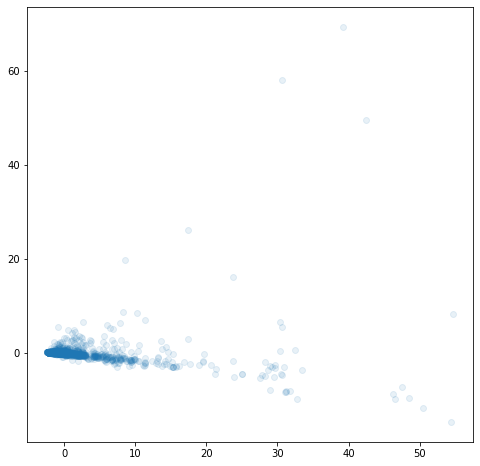

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
           alpha=.1)

Take a look at the explained variances (rounded to 3 decimal places).

In [76]:
np.round(pca.explained_variance_ratio_, 3)

array([0.299, 0.062, 0.048, 0.035, 0.029, 0.027, 0.023, 0.021, 0.021,
       0.017, 0.016, 0.015, 0.015, 0.014, 0.014, 0.013, 0.013, 0.013,
       0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.012, 0.012,
       0.012, 0.012, 0.011, 0.011, 0.01 , 0.01 , 0.01 , 0.009, 0.009,
       0.008, 0.008, 0.008, 0.007, 0.007, 0.006, 0.006, 0.005, 0.005,
       0.005, 0.004, 0.004, 0.004, 0.003, 0.003, 0.002, 0.002, 0.002,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

Explained variances of the first 10 principal components.

In [81]:
[sum(pca.explained_variance_ratio_[:k+1]) for k in range(10)]

[0.2991728210243914,
 0.3616708773997827,
 0.4098135833456267,
 0.4446241416859806,
 0.47365135962649974,
 0.5010366188491857,
 0.5240781475769801,
 0.5454678523516316,
 0.565991375883063,
 0.5831500139197913]

Plot first three components.

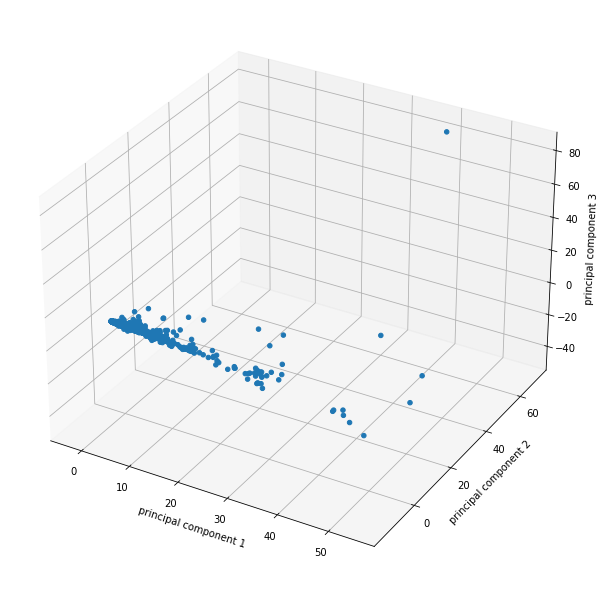

In [98]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)

xx = principalDf['principal component 1']
yy = principalDf['principal component 2']
zz = principalDf['principal component 3']

ax.scatter(xx, yy, zz, alpha=1)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')
plt.show()

So even though the first three principal components only explain approximately 40 percent of the data, it still has enough structure. In fact, by decreasing the opacity of points we see the majority of sample points follow the trajectory of principal component 1.

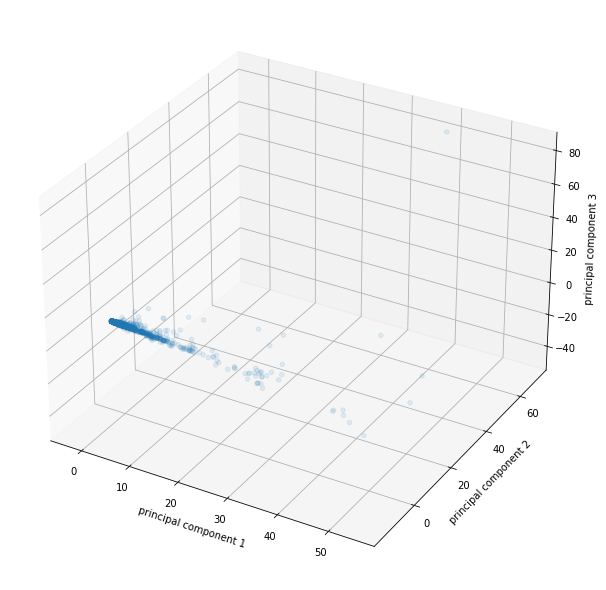

In [109]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)

xx = principalDf['principal component 1']
yy = principalDf['principal component 2']
zz = principalDf['principal component 3']

ax.scatter(xx, yy, zz, alpha=.1)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')
plt.show()

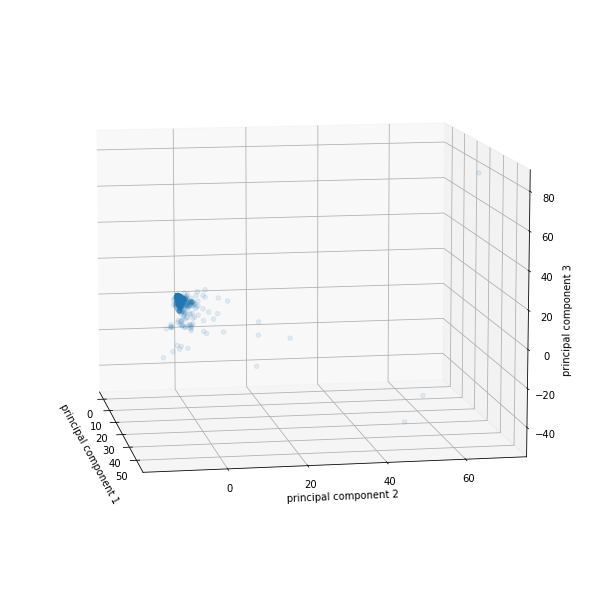

In [110]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)

xx = principalDf['principal component 1']
yy = principalDf['principal component 2']
zz = principalDf['principal component 3']

ax.scatter(xx, yy, zz, alpha=.1)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')

ax.view_init(10, -10)

plt.show()

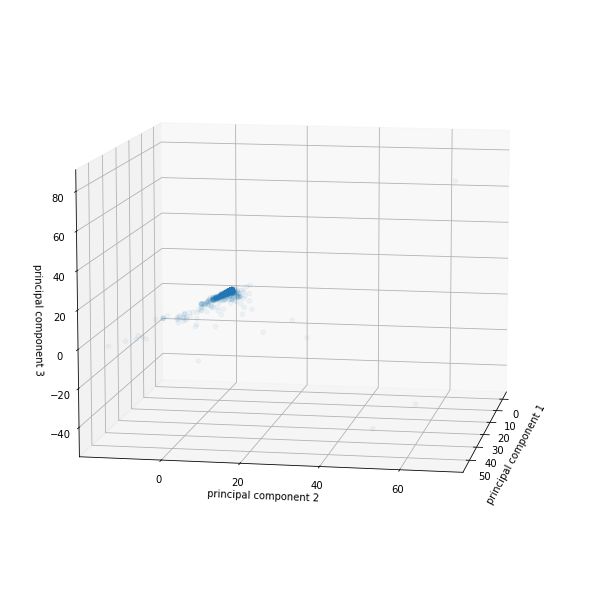

In [108]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)

xx = principalDf['principal component 1']
yy = principalDf['principal component 2']
zz = principalDf['principal component 3']

ax.scatter(xx, yy, zz, alpha=.05)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')

ax.view_init(10, 10)

plt.show()